### Let's try to check the particle energy spectrum

### We need something like this:

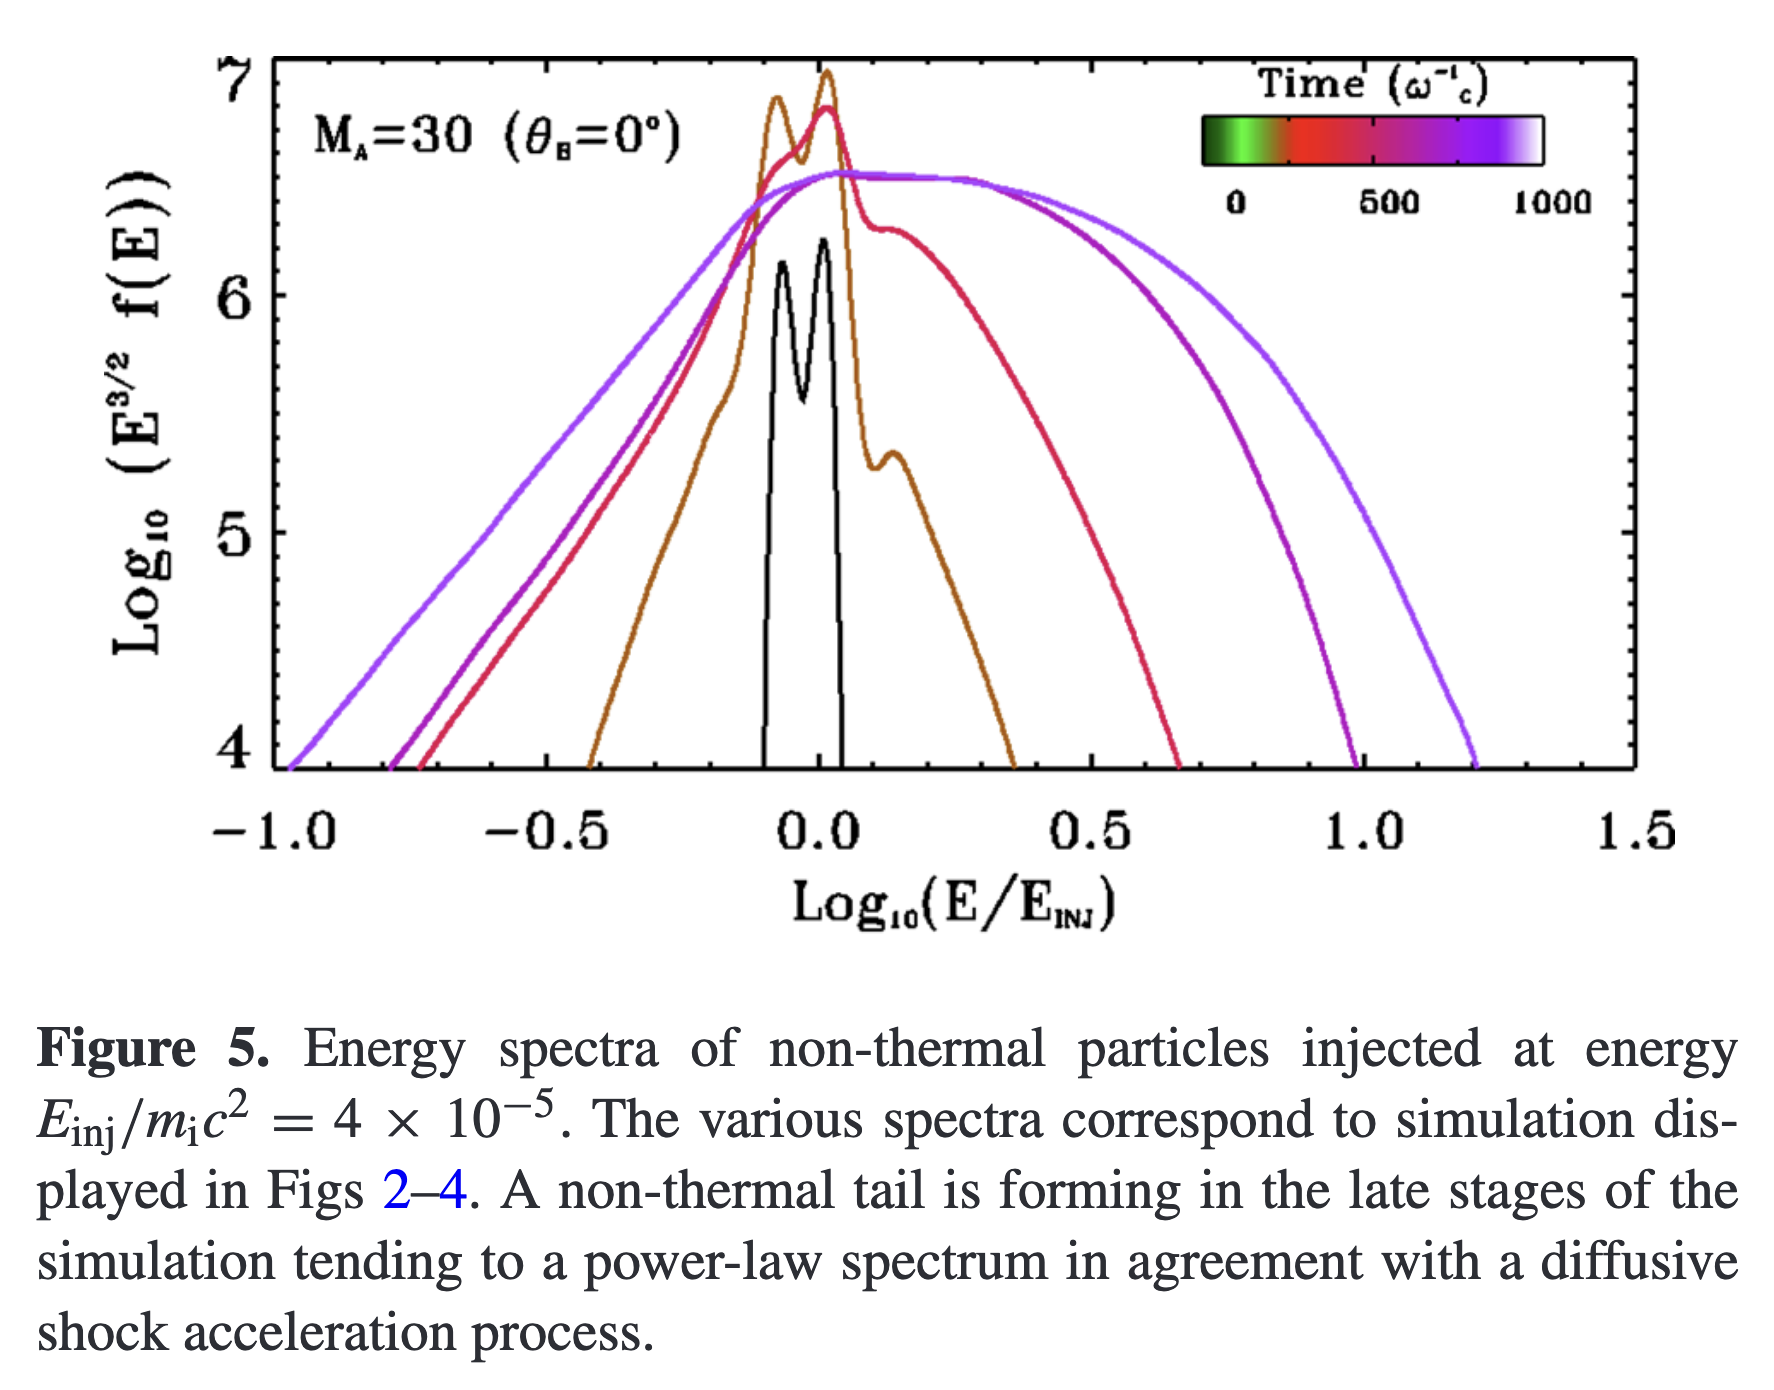

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
x, y, z, vx, vy, vz = np.genfromtxt(
    '/Users/yao/Documents/Data/AMRVAC/test4/test_0001.pic1', 
    usecols=(0,1,2,3,4,5), 
    skip_footer=3,
    unpack=True)

In [5]:
import numpy as np
import matplotlib.pyplot as plt

eV = 1.602176634e-19
c  = 2.99792458e8

def _kinetic_energy(vx, vy, vz, m, *, v_unit="si", mode="auto"):
    vx, vy, vz = map(np.asarray, (vx, vy, vz))
    if v_unit == "si":
        beta2 = (vx*vx + vy*vy + vz*vz) / c**2
    elif v_unit == "c":
        beta2 = vx*vx + vy*vy + vz*vz
    else:
        raise ValueError("v_unit must be 'si' or 'c'")
    beta_max = float(np.sqrt(beta2.max())) if beta2.size else 0.0
    mode_eff = "rel" if (mode == "auto" and beta_max > 0.1) else (mode if mode != "auto" else "nonrel")
    if mode_eff == "nonrel":
        E_J = 0.5 * m * (beta2 * c**2)
    else:
        gamma = 1.0 / np.sqrt(1.0 - np.clip(beta2, 0.0, 1-1e-15))
        E_J = (gamma - 1.0) * m * c**2
    return E_J, mode_eff, beta_max

def plot_cr_spectrum_E32f_logx(
    vx, vy, vz, m, *,
    v_unit="si",
    mode="auto",
    weights=None,            # PIC macro-particle weights (same length)
    E_inj_eV=38e3,           # 38 keV default
    bins=120,
    Emin_over_Einj=None,     # normalized bin range
    Emax_over_Einj=None,
    label=None,
    ax=None,
    line_kwargs=None         # e.g., dict(lw=2, alpha=0.9)
):
    """
    Plot a smooth curve: y = log10(E^(3/2) f(E)) vs x = log10(E/E_inj),
    where f(E) is the differential PDF from a histogram in E (geom bins).
    Returns (x_log10, y, centers_E_eV, fE, edges_E_eV, mode_used, beta_max).
    """
    if line_kwargs is None:
        line_kwargs = dict(lw=2)

    # energies (eV)
    E_J, mode_used, beta_max = _kinetic_energy(vx, vy, vz, m, v_unit=v_unit, mode=mode)
    E_eV = E_J / eV
    if not np.any(E_eV > 0):
        raise ValueError("All energies are zero or negative.")

    # bin range
    Epos = E_eV[E_eV > 0]
    Einj = float(E_inj_eV)
    Emin = (Emin_over_Einj * Einj) if Emin_over_Einj is not None else max(Epos.min(), 1e-12*Einj)
    Emax = (Emax_over_Einj * Einj) if Emax_over_Einj is not None else Epos.max()
    Emin = max(Emin, 1e-30)
    Emax = max(Emax, Emin * 10)

    # histogram in E with geometric bins (keeps f(E) wrt dE)
    edges_E = np.geomspace(Emin, Emax, bins + 1)
    fE, edges_E = np.histogram(E_eV, bins=edges_E, weights=weights, density=True)
    centers_E = 0.5 * (edges_E[1:] + edges_E[:-1])

    # x: log10(E/Einj) at bin centers
    x_log10 = np.log10(centers_E / Einj)

    # y: log10(E^(3/2) f(E)) at bin centers
    y = np.full_like(centers_E, np.nan, dtype=float)
    mask = (centers_E > 0) & (fE > 0)
    y[mask] = np.log10(centers_E[mask]**1.5 * fE[mask])

    # smooth *line* by joining centers (no steps)
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(x_log10, y, '-', label=label, **line_kwargs)
    ax.set_xlabel(r"$\log_{10}\!\left(E/E_{\rm INJ}\right)$")
    ax.set_ylabel(r"$\log_{10}\!\left(E^{3/2} f(E)\right)$")
    ax.grid(True, which="both", ls=":")
    if label is not None:
        ax.legend()
    ax.set_title(f"CR spectrum (mode={mode_used}, max β={beta_max:.2f})")

    return x_log10, y, centers_E, fE, edges_E, mode_used, beta_max

In [6]:
mp = 1.67262192369e-27  # kg

E0, mode_eff0, beta_max0 = _kinetic_energy(vx, vy, vz, mp, mode="auto", v_unit="c")

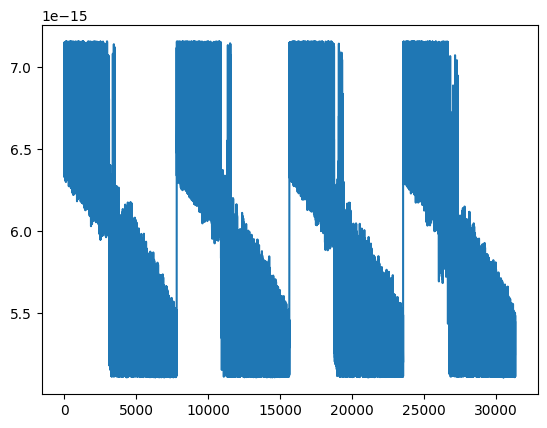

In [7]:
plt.plot(E0)

In [8]:
Einj = np.average(E0)/1.6e-19
print(Einj/1e3)

37.05541126424795


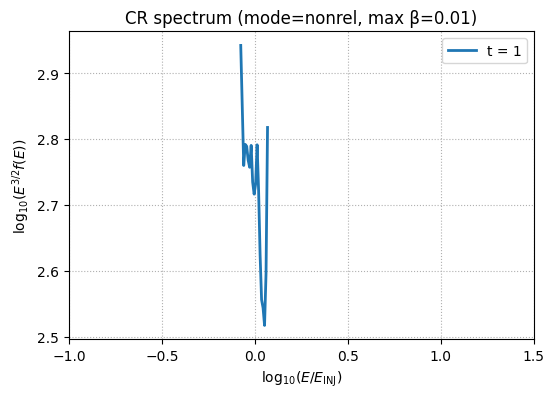

In [9]:
mp = 1.67262192369e-27  # proton mass [kg]
plot_cr_spectrum_E32f_logx(
    vx, vy, vz, m=mp, v_unit="c",
    E_inj_eV=38e3, bins=500,
    Emin_over_Einj=1e-2, Emax_over_Einj=1e2,
    label="t = 1",
    line_kwargs=dict(lw=2)
)
plt.xlim([-1.0, 1.5])
plt.show()

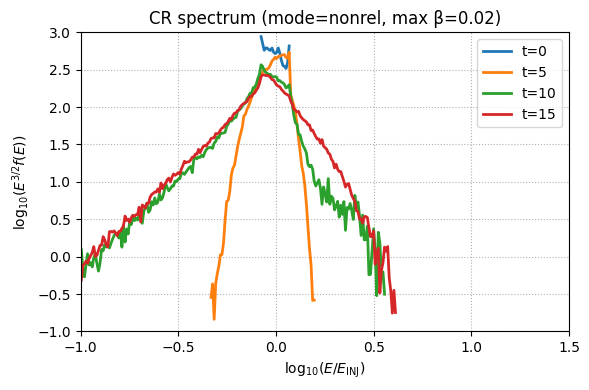

In [10]:
import numpy as np
import matplotlib.pyplot as plt

files  = [
    "/Users/yao/Documents/Data/AMRVAC/test4/test_0001.pic1",
    "/Users/yao/Documents/Data/AMRVAC/test4/test_0005.pic1",
    "/Users/yao/Documents/Data/AMRVAC/test4/test_0010.pic1",
    "/Users/yao/Documents/Data/AMRVAC/test4/test_0015.pic1",
]
labels = ["t=0", "t=5", "t=10", "t=15"]   # edit as you like

mp = 1.67262192369e-27   # proton mass [kg] (change if needed)

fig, ax = plt.subplots(figsize=(6,4))   # one figure, one axis

for f, lab in zip(files, labels):
    vx, vy, vz = np.genfromtxt(f, usecols=(3,4,5), skip_footer=3, unpack=True)

    plot_cr_spectrum_E32f_logx(
        vx, vy, vz, m=mp, v_unit="c",
        E_inj_eV=38e3,
        bins=500, Emin_over_Einj=1e-2, Emax_over_Einj=1e2,
        label=lab, ax=ax, line_kwargs=dict(lw=2)
    )

# ax.plot(bm[:,0], bm[:,1]/4, 'k--', lw=2, label='benchmark from paper')

ax.legend()
ax.set_xlim([-1.0, 1.5])
ax.set_ylim([-1, 3])
plt.tight_layout()
plt.show()
# plt.savefig('cr_spectrum.png', dpi=300)

In [16]:
bm = np.loadtxt('/Users/yao/Downloads/plot-data.csv',skiprows=1,delimiter=',')

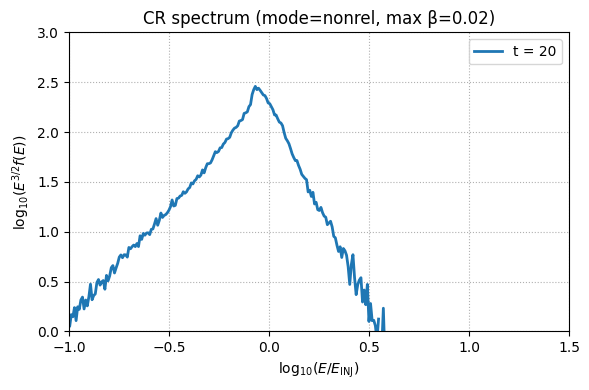

In [13]:
import numpy as np
import matplotlib.pyplot as plt

files  = [
    # "/Users/yao/Documents/Data/AMRVAC/test3/test_0001.pic1",
    # "/Users/yao/Documents/Data/AMRVAC/test3/test_0005.pic1",
    # "/Users/yao/Documents/Data/AMRVAC/test3/test_0010.pic1",
    # "/Users/yao/Documents/Data/AMRVAC/test3/test_0016.pic1",
    "/Users/yao/Documents/Data/AMRVAC/test4/test_0020.pic1",
]
# labels = ["t=0", "t=5", "t=10", "t=15"]   # edit as you like
labels = ['t = 20']

mp = 1.67262192369e-27   # proton mass [kg] (change if needed)

fig, ax = plt.subplots(figsize=(6,4))   # one figure, one axis

for f, lab in zip(files, labels):
    vx, vy, vz = np.genfromtxt(f, usecols=(3,4,5), skip_footer=3, unpack=True)

    plot_cr_spectrum_E32f_logx(
        vx, vy, vz, m=mp, v_unit="c",
        E_inj_eV=38e3,
        bins=500, Emin_over_Einj=1e-2, Emax_over_Einj=1e2,
        label=lab, ax=ax, line_kwargs=dict(lw=2)
    )

# ax.plot(bm[:,0], bm[:,1]/4, 'k--', lw=2, label='benchmark from paper')

ax.legend()
ax.set_xlim([-1.0, 1.5])
ax.set_ylim([0, 3])
plt.tight_layout()
plt.show()
# plt.savefig('cr_spectrum.png', dpi=300)